# Gradient boosting Optimization
In this notebook, data bucketing cutoff is finetuned.


In [1]:
%matplotlib inline
import os, glob
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
from IPython.display import display
#from pyearth import Earth

In [2]:
train = pd.read_csv(os.path.join('..','competition_data','train_set.csv'),header=0)
test = pd.read_csv(os.path.join('..','competition_data','test_set.csv'),header=0)
tubedf = pd.read_csv(os.path.join('..','competition_data','tube.csv'),  header=0)
compdf = pd.read_csv(os.path.join('..','competition_data','components.csv'), header=0,index_col=0)
billdf = pd.read_csv(os.path.join('..','competition_data','bill_of_materials.csv'),header=0)

In [3]:
def replace_comp_id_x(inp_df, comp_df, col_index, id_no):
    """
    Replaces the component id with component name and component id type 
    in the input dataframe
    """
    column = inp_df.columns[col_index]
    name = []
    comp_typeid = []
    for comp_id in inp_df[column].values:
        if isinstance(comp_id,str):
            name.append(comp_df.loc[comp_id,'name'])
            comp_typeid.append(comp_df.component_type_id[comp_id])
        else:
            name.append(np.nan)
            comp_typeid.append(np.nan)
    name = np.array(name)
    comp_typeid = np.array(comp_typeid)
    out_df = inp_df.drop(column,axis=1)
    out_df.insert(col_index, 'component_id_name_'+str(id_no), name)
    out_df.insert(col_index+1,'component_type_id_'+str(id_no),comp_typeid)
    return out_df


In [4]:
billdfm = billdf.copy()
billdfm = replace_comp_id_x(billdfm, compdf, 1, 1)
billdfm = replace_comp_id_x(billdfm, compdf, 4, 2)
billdfm = replace_comp_id_x(billdfm, compdf, 7, 3)
billdfm = replace_comp_id_x(billdfm, compdf, 10, 4)
billdfm = replace_comp_id_x(billdfm, compdf, 13, 5)
billdfm = replace_comp_id_x(billdfm, compdf, 16, 6)
billdfm = replace_comp_id_x(billdfm, compdf, 19, 7)
billdfm = replace_comp_id_x(billdfm, compdf, 22, 8)

In [5]:
train_test = train.append(test,ignore_index=True)
train_testm1 = train_test.merge(tubedf,on='tube_assembly_id')
train_testm2 = train_testm1.merge(billdfm,on='tube_assembly_id')

In [6]:
class PruneLabelEncoder(LabelEncoder):
    def __init___(self):
        super(PruneLabelEncoder, self).__init__()
    def fit(self, series, cutoff=10):
        self.cutoff = cutoff
        # Generate the transformation classes and also the map for low output munging 
        super(PruneLabelEncoder, self).fit(series)
        trans_series = super(PruneLabelEncoder, self).transform(series)
        self.val_count_map = defaultdict(int)
        for i in trans_series:
            self.val_count_map[i] += 1
        # identify the first key with low frequency and use it for all low freq vals
        for key, val in self.val_count_map.items():
            if val < self.cutoff:
                self.low_cnt_target = key
                break
    def transform(self, series):
        trans_series = super(PruneLabelEncoder, self).transform(series)
        # Transform all the low frequency keys into the low frequency target key
        for key, val in self.val_count_map.items():
            if val < self.cutoff:
                trans_series[trans_series==key] = self.low_cnt_target
        return trans_series
            
        

In [7]:
TRANSFORM_CUTOFF = 25

In [8]:
lbl_enc_comp_typeid = PruneLabelEncoder()
comp_id1 = train_testm2.component_type_id_1.values
comp_id2 = train_testm2.component_type_id_2.values
comp_id3 = train_testm2.component_type_id_3.values
comp_id = np.concatenate((comp_id1, comp_id2, comp_id3))
lbl_enc_comp_typeid.fit(comp_id, cutoff=TRANSFORM_CUTOFF)  

lbl_enc_comp_name = PruneLabelEncoder()
comp_id_name1 = train_testm2.component_id_name_1.values
comp_id_name2 = train_testm2.component_id_name_2.values
comp_id_name3 = train_testm2.component_id_name_3.values
comp_id_name = np.concatenate((comp_id_name1, comp_id_name2, comp_id_name3))
lbl_enc_comp_name.fit(comp_id_name, cutoff=TRANSFORM_CUTOFF)  

lbl_enc_mat_id = PruneLabelEncoder()
lbl_enc_mat_id.fit(train_testm2.material_id.values, cutoff=TRANSFORM_CUTOFF)  
lbl_enc_splr_id = PruneLabelEncoder()
lbl_enc_splr_id.fit(train_testm2.supplier.values, cutoff=TRANSFORM_CUTOFF)

enda_vals = train_testm2.end_a.values
endx_vals = train_testm2.end_x.values
end_vals = np.concatenate((enda_vals, endx_vals))
lbl_enc_end = PruneLabelEncoder()
lbl_enc_end.fit(end_vals, cutoff=TRANSFORM_CUTOFF) 

/Users/mbkumar/venv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Users/mbkumar/venv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:251: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [9]:
trainm1 = train.merge(tubedf,on='tube_assembly_id')
trainm2 = trainm1.merge(billdfm,on='tube_assembly_id')

In [10]:
def get_year_month_offset(date_ser, ref_date):
    dates = list(date_ser.values)
    dates_conv = map(pd.to_datetime,dates)
    years = [date.year for date in dates_conv]
    months = [date.month for date in dates_conv]
    ref_date_conv = pd.to_datetime(ref_date)
    days = [(date-ref_date_conv).days for date in dates_conv]
    return years, months, days

In [11]:
years, months, ofsetdates = get_year_month_offset(trainm2.quote_date, '2010-12-31')

In [12]:
print 'length of data', len(trainm2)
print 'Null vals in comp1', np.sum(trainm2.quantity_1.isnull().values)
print 'Null vals in comp2', np.sum(trainm2.quantity_2.isnull().values)
print 'Null vals in comp3', np.sum(trainm2.quantity_3.isnull().values)
print 'Null vals in comp4', np.sum(trainm2.quantity_4.isnull().values)
print 'Null vals in comp5', np.sum(trainm2.quantity_5.isnull().values)
print 'Null vals in comp6', np.sum(trainm2.quantity_6.isnull().values)
print 'Null vals in comp7', np.sum(trainm2.quantity_7.isnull().values)
print 'Null vals in comp8', np.sum(trainm2.quantity_8.isnull().values)

length of data 30213
Null vals in comp1 1462
Null vals in comp2 9129
Null vals in comp3 23042
Null vals in comp4 29426
Null vals in comp5 30147
Null vals in comp6 30185
Null vals in comp7 30205
Null vals in comp8 30210


In the predictor 'comp_id_x' related data where x = 4,5,6,7,8 is unncessary since the non null data is < 2.6%
In addition tube_assembly id is removed from now on.

In [13]:
trainp = trainm2.loc[:,[u'supplier', u'quote_date', u'annual_usage',
       u'min_order_quantity', u'bracket_pricing', u'quantity', 
       u'material_id', u'diameter', u'wall', u'length', u'num_bends',
       u'bend_radius', u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x',
       u'end_a', u'end_x', u'num_boss', u'num_bracket', u'other',
       u'component_id_name_1', u'component_type_id_1', u'quantity_1',
       u'component_id_name_2', u'component_type_id_2', u'quantity_2',
       u'component_id_name_3', u'component_type_id_3', u'quantity_3',
       'cost']]
trainp = trainp.drop('quote_date',axis=1)
trainp.insert(1, 'year', years)
trainp.insert(2, 'month', months)
trainp.insert(3, 'days', ofsetdates)

num_boss, num_brack and other have one or two high frequency values and then few low frequency values

## Categorical variables pruning
The categorical variables such as supplier_id, material_id, component_id_x_name, 
end_x, end_a with string categories are converted to integer
labels. The values with high frequencies are retained and the low
frequency values (<50) are all combined into a single value

In [14]:
print trainp.component_id_name_1.value_counts()[0:16]
print trainp.component_id_name_2.value_counts()[0:9]
print trainp.component_id_name_3.value_counts()[0:5]

NUT-SWIVEL         14172
NUT-FLARED          5771
NUT                 2237
CONNECTOR-SEAL      1734
nan                 1462
NUT-INV FLARED       821
FLANGE               585
SLEEVE-ORFS          472
SLEEVE-FITTING       472
BOSS                 333
CONNECTOR            255
HEAD-FLANGED         204
ELBOW                197
FLANGE-ONE PIEC      135
ADAPTER              108
ELBOW-90 DEG          93
dtype: int64
SLEEVE-ORFS       13617
nan                9129
SLEEVE-FLARED      1872
SLEEVE             1414
NUT-SWIVEL          939
NUT-FITTING         466
CONNECTOR-SEAL      412
ELBOW-90 DEG        200
NUT                 178
dtype: int64
nan               23058
CONNECTOR-SEAL     4117
SLEEVE-ORFS         702
ELBOW-90 DEG        342
CONNECTOR           209
dtype: int64


In [15]:
print sum(trainp.component_id_name_1.isnull().values)
print sum(trainp.component_id_name_2.isnull().values)
print sum(trainp.component_id_name_3.isnull().values)

0
0
0


In [18]:
comp_id1_trans = lbl_enc_comp_typeid.transform(trainp.component_type_id_1.values)
comp_id2_trans = lbl_enc_comp_typeid.transform(trainp.component_type_id_2.values)
comp_id3_trans = lbl_enc_comp_typeid.transform(trainp.component_type_id_3.values)
matid_trans = lbl_enc_mat_id.transform(trainp.material_id.values)
splr_trans = lbl_enc_splr_id.transform(trainp.supplier.values)
end_a_trans = lbl_enc_end.transform(trainp.end_a.values)
end_x_trans = lbl_enc_end.transform(trainp.end_x.values)

end_x_1x_vals = [1 if x=='Y' else 0 for x in trainp.end_x_1x.values]
end_a_1x_vals = [1 if x=='Y' else 0 for x in trainp.end_a_1x.values]
end_x_2x_vals = [1 if x=='Y' else 0 for x in trainp.end_x_2x.values]
end_a_2x_vals = [1 if x=='Y' else 0 for x in trainp.end_a_2x.values]
brack_price_vals = [1 if x=='Yes' else 0 for x in trainp.bracket_pricing.values]

# NaN removal for Quantity_x where x = 1,2,3 contain nan. converting nan to zero.

quant1 = [0 if np.isnan(x) else x for x in trainp.quantity_1.values]
quant2 = [0 if np.isnan(x) else x for x in trainp.quantity_2.values]
quant3 = [0 if np.isnan(x) else x for x in trainp.quantity_3.values]

The first four material ids have high frequencies. Its better to assign those 4 to 
different values and group the rest into a single value

In [19]:
trainp1 = trainp.loc[:,[u'year', u'month', u'days', u'annual_usage',
       u'min_order_quantity', u'quantity', 
       u'diameter', u'wall', u'length', u'num_bends',
       u'bend_radius', u'num_boss', u'num_bracket', u'other', u'cost']]
# Reencode the categorical variables
trainp1.insert(0, 'supplier', splr_trans, allow_duplicates=False)
trainp1.insert(6, 'bracket_pricing', brack_price_vals, allow_duplicates=False)
trainp1.insert(8, 'material_id', matid_trans, allow_duplicates=False)
trainp1.insert(14, 'end_a_1x', end_a_1x_vals, allow_duplicates=False)
trainp1.insert(15, 'end_a_2x', end_a_2x_vals, allow_duplicates=False)
trainp1.insert(16, 'end_x_1x', end_x_1x_vals, allow_duplicates=False)
trainp1.insert(17, 'end_x_2x', end_x_2x_vals, allow_duplicates=False)
trainp1.insert(18, 'end_a', end_a_trans, allow_duplicates=False)
trainp1.insert(19, 'end_x', end_x_trans, allow_duplicates=False)
trainp1.insert(23, 'component_type_id_1', comp_id1_trans, allow_duplicates=False)
trainp1.insert(24, 'quantity_1', quant1, allow_duplicates=False)
trainp1.insert(25, 'component_type_id_2', comp_id2_trans, allow_duplicates=False)
trainp1.insert(26, 'quantity_2', quant2, allow_duplicates=False)
trainp1.insert(27, 'component_type_id_3', comp_id3_trans, allow_duplicates=False)
trainp1.insert(28, 'quantity_3', quant3, allow_duplicates=False)
trainp1 =  trainp1.drop('end_a_1x',1)
trainp1.columns

Index([           u'supplier',                u'year',               u'month',
                      u'days',        u'annual_usage',  u'min_order_quantity',
           u'bracket_pricing',            u'quantity',         u'material_id',
                  u'diameter',                u'wall',              u'length',
                 u'num_bends',         u'bend_radius',            u'end_a_2x',
                  u'end_x_1x',            u'end_x_2x',               u'end_a',
                     u'end_x',            u'num_boss',         u'num_bracket',
                     u'other', u'component_type_id_1',          u'quantity_1',
       u'component_type_id_2',          u'quantity_2', u'component_type_id_3',
                u'quantity_3',                u'cost'],
      dtype='object')

In [20]:
X_cols = trainp1.columns[:-1]
print X_cols
print len(trainp1)


Index([           u'supplier',                u'year',               u'month',
                      u'days',        u'annual_usage',  u'min_order_quantity',
           u'bracket_pricing',            u'quantity',         u'material_id',
                  u'diameter',                u'wall',              u'length',
                 u'num_bends',         u'bend_radius',            u'end_a_2x',
                  u'end_x_1x',            u'end_x_2x',               u'end_a',
                     u'end_x',            u'num_boss',         u'num_bracket',
                     u'other', u'component_type_id_1',          u'quantity_1',
       u'component_type_id_2',          u'quantity_2', u'component_type_id_3',
                u'quantity_3'],
      dtype='object')
30213


# Randomize the data

In [21]:
train_shfl = trainp1.iloc[np.random.permutation(len(trainp1))]

In [22]:
X = train_shfl.as_matrix(train_shfl.columns[:-1])
y = train_shfl.as_matrix(['cost'])[:,0]
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

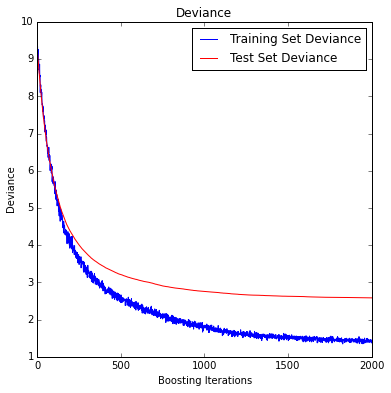

In [26]:
###############################################################################
# Fit regression model
params = {'n_estimators': 4000, 'max_depth': 10, 'min_samples_split': 6,
          'learning_rate': 0.01, 'loss': 'lad', 'subsample': 0.7}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim( 0, 2000 )
plt.ylabel('Deviance')

plt.show()

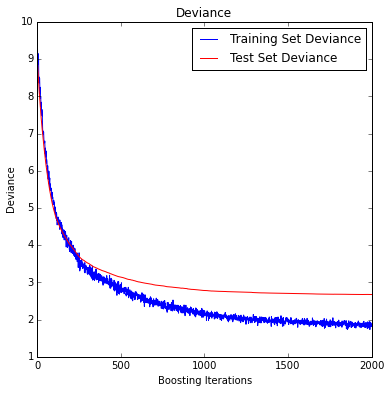

In [47]:
###############################################################################
# Fit regression model
params = {'n_estimators': 2000, 'max_depth': 8, 'min_samples_split': 6,
          'learning_rate': 0.015, 'loss': 'lad', 'subsample': 0.7}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim( 0, 2000 )
plt.ylabel('Deviance')

plt.show()

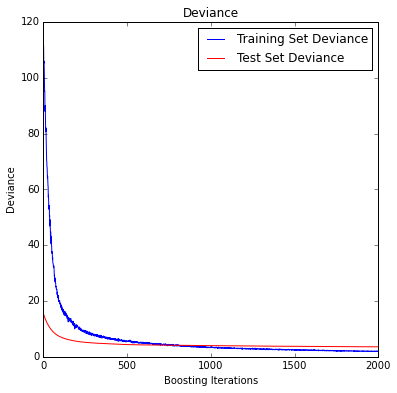

In [45]:
###############################################################################
# Fit regression model
params = {'n_estimators': 2000, 'max_depth': 7, 'min_samples_split': 6,
          'learning_rate': 0.015, 'loss': 'huber', 'subsample': 0.7}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim(0, 2000)
plt.ylabel('Deviance')

plt.show()

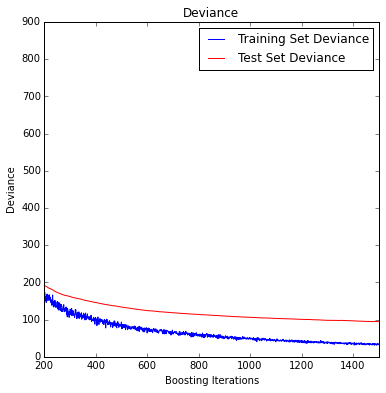

In [41]:
###############################################################################
# Fit regression model
params = {'n_estimators': 1500, 'max_depth': 5, 'min_samples_split': 6,
          'learning_rate': 0.015, 'loss': 'ls', 'subsample': 0.7}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim( 200, 1500 )
plt.ylabel('Deviance')

plt.show()

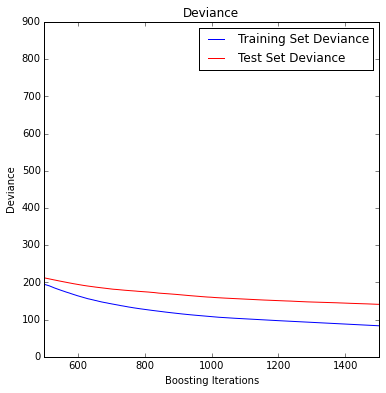

In [38]:
###############################################################################
# Fit regression model
params = {'n_estimators': 1500, 'max_depth': 5, 'min_samples_split': 5,
          'learning_rate': 0.005, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim( 500, 1500 )
plt.ylabel('Deviance')

plt.show()

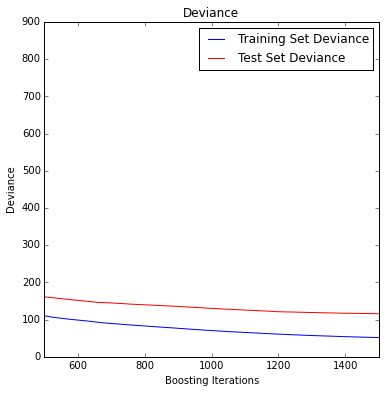

In [36]:
###############################################################################
# Fit regression model
params = {'n_estimators': 1500, 'max_depth': 5, 'min_samples_split': 7,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim( 500, 1500 )
plt.ylabel('Deviance')

plt.show()

In [ ]:
###############################################################################
# Fit regression model
params = {'n_estimators': 1500, 'max_depth': 5, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
xlim( 500, 1500 )
plt.ylabel('Deviance')

plt.show()

In [ ]:
###############################################################################
# Fit regression model
params = {'n_estimators': 1500, 'max_depth': 5, 'min_samples_split': 7,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
xlim( 500, 1500 )
plt.ylabel('Deviance')

plt.show()

In [122]:
gbr = GradientBoostingRegressor(n_estimators=2000,max_depth=6,min_samples_split=6)

In [24]:
gbr.get_params()

{'alpha': 0.9,
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [26]:
param_grids = {'max_depth': [3,4,5,7], 'min_samples_split': [2,4,6], 
               'n_estimators': [1200] }

In [29]:
gs_clf = GridSearchCV(gbr,param_grids,scoring='mean_absolute_error', cv=10)

In [30]:
gs_clf.fit(train_X,train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': [2, 4, 6], 'n_estimators': [1200], 'max_depth': [3, 4, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

In [33]:
gs_clf.best_params_

{'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 1200}

In [34]:
gs_clf.best_score_

-0.92218723767427391

In [23]:
def rmsle_fn(y_true, y_pred):
    from math import log, sqrt
    assert len(y_true) == len(y_pred)
    # Convert all negative y_pred to zero
    y_pred[y_pred < 0] = 0
    rmsle = 0
    for pair in zip(y_true, y_pred):
        log_diff = log(1+pair[1]) - log(1+pair[0]) 
        rmsle += log_diff*log_diff
    rmsle = sqrt(rmsle/len(y_true))
    return rmsle

In [24]:
rmsle_loss = make_scorer(rmsle_fn, greater_is_better=False)

In [26]:
gbr_opt = GradientBoostingRegressor(n_estimators=2000,min_samples_split=6,max_depth=7,
                                    learning_rate=0.015, loss='lad', subsample=0.7)

In [27]:
params = {'n_estimators': 4000, 'max_depth': 10, 'min_samples_split': 6,
          'learning_rate': 0.01, 'loss': 'lad', 'subsample': 0.7}
gbr_opt = GradientBoostingRegressor(**params)

In [51]:
scores = cross_validation.cross_val_score(gbr_opt, X, y, cv=5, n_jobs=-1)
scores

array([ 0.68767565,  0.6404721 ,  0.79787374,  0.73143818,  0.67932458])

In [52]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.11)


In [24]:
scores = cross_validation.cross_val_score(gbr_opt, X, y, scoring=rmsle_loss, cv=5)
print("Loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

array([-0.24801607, -0.22412583, -0.23491087, -0.23581297, -0.24393205])

In [33]:
scores = cross_validation.cross_val_score(gbr_opt, X, y, scoring=rmsle_loss, cv=5)
print("Loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

Loss: -0.22 (+/- 0.03)


array([-0.21623896, -0.24367865, -0.21750908, -0.20910417, -0.23312248])

Loss: -0.24 (+/- 0.02)


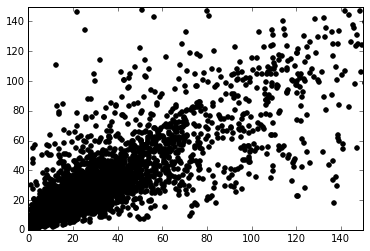

In [29]:
pred_y = cross_validation.cross_val_predict(gbr_opt,X,y, cv=6, n_jobs=-1)
#pred_y = cross_validation.cross_val_predict?
plt.scatter(y, pred_y,  color='black')
plt.xlim((0,150))
plt.ylim ((0,150))

plt.show()

In [44]:
train_X.shape

(30213, 29)

In [28]:
gbr_opt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=4000,
             random_state=None, subsample=0.7, verbose=0, warm_start=False)

In [29]:
gbr_opt.feature_importances_

array([ 0.03926065,  0.01262016,  0.04214281,  0.11080198,  0.09718763,
        0.05628421,  0.00655663,  0.13202359,  0.02533595,  0.04459537,
        0.03265926,  0.13735256,  0.04713672,  0.03859842,  0.00881529,
        0.00675933,  0.00724438,  0.0209821 ,  0.02271627,  0.00554701,
        0.00175234,  0.00500544,  0.03393838,  0.00915174,  0.0213668 ,
        0.00980012,  0.01801052,  0.00635433])

In [30]:
testm1 = test.merge(tubedf,on='tube_assembly_id')
testm2 = testm1.merge(billdfm,on='tube_assembly_id')

In [31]:
years, months, ofsetdates = get_year_month_offset(testm2.quote_date, '2010-12-31')
testp = testm2.loc[:,[u'supplier', u'quote_date', u'annual_usage',
       u'min_order_quantity', u'bracket_pricing', u'quantity', 
       u'material_id', u'diameter', u'wall', u'length', u'num_bends',
       u'bend_radius', u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x',
       u'end_a', u'end_x', u'num_boss', u'num_bracket', u'other',
       u'component_id_name_1', u'component_type_id_1', u'quantity_1',
       u'component_id_name_2', u'component_type_id_2', u'quantity_2',
       u'component_id_name_3', u'component_type_id_3', u'quantity_3',
       'cost']]
testp = testp.drop('quote_date',axis=1)
testp.insert(1, 'year', years)
testp.insert(2, 'month', months)
testp.insert(3, 'days', ofsetdates)

In [34]:
comp_id1_trans = lbl_enc_comp_typeid.transform(testp.component_type_id_1.values)
comp_id2_trans = lbl_enc_comp_typeid.transform(testp.component_type_id_2.values)
comp_id3_trans = lbl_enc_comp_typeid.transform(testp.component_type_id_3.values)
matid_trans = lbl_enc_mat_id.transform(testp.material_id.values)
splr_trans = lbl_enc_splr_id.transform(testp.supplier.values)
end_a_trans = lbl_enc_end.transform(testp.end_a.values)
end_x_trans = lbl_enc_end.transform(testp.end_x.values)

end_x_1x_vals = [1 if x=='Y' else 0 for x in testp.end_x_1x.values]
end_a_1x_vals = [1 if x=='Y' else 0 for x in testp.end_a_1x.values]
end_x_2x_vals = [1 if x=='Y' else 0 for x in testp.end_x_2x.values]
end_a_2x_vals = [1 if x=='Y' else 0 for x in testp.end_a_2x.values]
brack_price_vals = [1 if x=='Yes' else 0 for x in testp.bracket_pricing.values]

quant1 = [0 if np.isnan(x) else x for x in testp.quantity_1.values]
quant2 = [0 if np.isnan(x) else x for x in testp.quantity_2.values]
quant3 = [0 if np.isnan(x) else x for x in testp.quantity_3.values]

testp1 = testp.loc[:,[u'year', u'month', u'days', u'annual_usage',
       u'min_order_quantity', u'quantity', 
       u'diameter', u'wall', u'length', u'num_bends',
       u'bend_radius', u'num_boss', u'num_bracket', u'other']]
# Reencode the categorical variables
testp1.insert(0, 'supplier', splr_trans, allow_duplicates=False)
testp1.insert(6, 'bracket_pricing', brack_price_vals, allow_duplicates=False)
testp1.insert(8, 'material_id', matid_trans, allow_duplicates=False)
testp1.insert(14, 'end_a_1x', end_a_1x_vals, allow_duplicates=False)
testp1.insert(15, 'end_a_2x', end_a_2x_vals, allow_duplicates=False)
testp1.insert(16, 'end_x_1x', end_x_1x_vals, allow_duplicates=False)
testp1.insert(17, 'end_x_2x', end_x_2x_vals, allow_duplicates=False)
testp1.insert(18, 'end_a', end_a_trans, allow_duplicates=False)
testp1.insert(19, 'end_x', end_x_trans, allow_duplicates=False)
testp1.insert(23, 'component_type_id_1', comp_id1_trans, allow_duplicates=False)
testp1.insert(24, 'quantity_1', quant1, allow_duplicates=False)
testp1.insert(25, 'component_type_id_2', comp_id2_trans, allow_duplicates=False)
testp1.insert(26, 'quantity_2', quant2, allow_duplicates=False)
testp1.insert(27, 'component_type_id_3', comp_id3_trans, allow_duplicates=False)
testp1.insert(28, 'quantity_3', quant3, allow_duplicates=False)
testp1 = testp1.drop('end_a_1x',1)
testp1.columns

Index([           u'supplier',                u'year',               u'month',
                      u'days',        u'annual_usage',  u'min_order_quantity',
           u'bracket_pricing',            u'quantity',         u'material_id',
                  u'diameter',                u'wall',              u'length',
                 u'num_bends',         u'bend_radius',            u'end_a_2x',
                  u'end_x_1x',            u'end_x_2x',               u'end_a',
                     u'end_x',            u'num_boss',         u'num_bracket',
                     u'other', u'component_type_id_1',          u'quantity_1',
       u'component_type_id_2',          u'quantity_2', u'component_type_id_3',
                u'quantity_3'],
      dtype='object')

In [35]:
for column in testp1.columns:
    no_null = np.sum(testp1[column].isnull())
    if no_null:
        print column, no_null

In [36]:
test_X = testp1.as_matrix(testp1.columns)
test_X.shape

(30235, 28)

In [37]:
testp1.num_bracket.value_counts()

0    30131
1       85
2       18
4        1
dtype: int64

In [38]:
test_y_pred = gbr_opt.predict(test_X)
test_y_pred[test_y_pred<0] = 0.1
test_y_pred_ser = pd.Series(data=test_y_pred,name='cost')
test_y_pred_ser.to_csv(os.path.join('..','competition_data','cost_predicted_model8a.csv'))
